# PRODUCT RECOMMENDER SYSTEM

## Importing Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Loading Dataset

In [11]:
df=pd.read_csv(r"C:\datasets\merrec.csv")

In [13]:
df.head()

,user_id,item_id,session_id,action_type,timestamp,category,price,title
0,user_722,item_4258,session_471,click,2023-04-06T01:40:17,home,312.56,Item 0
1,user_399,item_4200,session_704,favorite,2023-04-22T06:43:36,electronics,49.71,Item 1
2,user_290,item_4654,session_2189,click,2023-04-29T02:51:06,fashion,406.19,Item 2
3,user_8,item_655,session_2621,favorite,2023-04-04T11:54:45,electronics,421.67,Item 3
4,user_621,item_2425,session_1124,click,2023-04-12T04:32:40,fashion,78.23,Item 4


## Data Preprocessing

In [18]:
df.isnull().sum()

user_id        0
item_id        0
session_id     0
action_type    0
timestamp      0
category       0
price          0
title          0
label          0
dtype: int64

In [20]:
df['label'] = (df['action_type'] == 'favorite').astype(int)

In [22]:
# Encode categorical columns

In [24]:
label_encoders = {}
for col in ['user_id', 'item_id', 'session_id', 'category', 'title']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [26]:
# Selecting features and target x,y

In [28]:
features = ['user_id', 'item_id', 'session_id', 'category', 'price']
X = df[features]
y = df['label']


In [30]:
#Train-Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 ## Define and Train Supervised Models

In [35]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

In [37]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }


In [39]:
metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

In [41]:
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression    0.7945   0.000000  0.000000  0.000000  0.504746
1        Decision Tree    0.6500   0.172336  0.184915  0.178404  0.477605
2        Random Forest    0.7890   0.133333  0.004866  0.009390  0.484632
3    Gradient Boosting    0.7920   0.142857  0.002433  0.004785  0.539085
4                  SVM    0.7945   0.000000  0.000000  0.000000  0.463422
5                  KNN    0.7540   0.170732  0.051095  0.078652  0.480190


In [49]:
#Visualize Evaluation Metrics

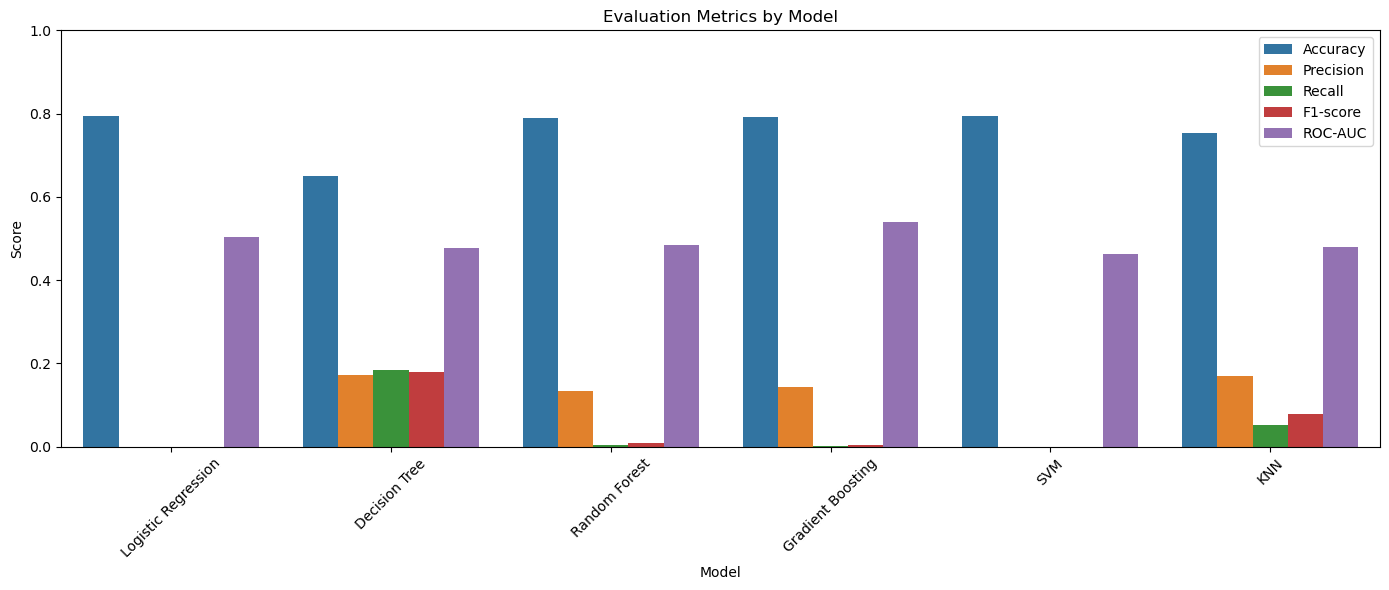

In [51]:
plt.figure(figsize=(14, 6))
melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.title("Evaluation Metrics by Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [45]:
#Plot Confusion Matrices for All Models

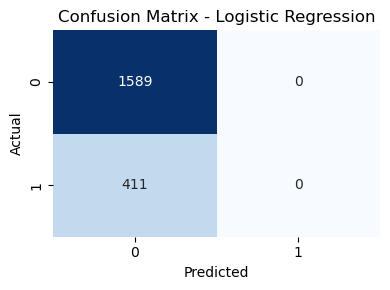

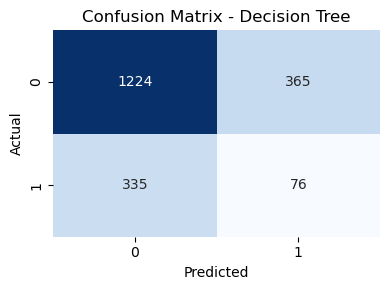

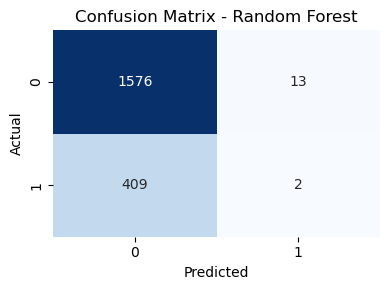

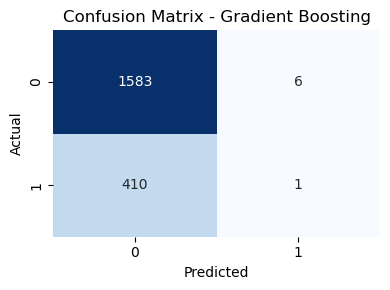

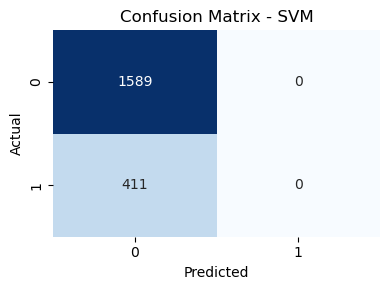

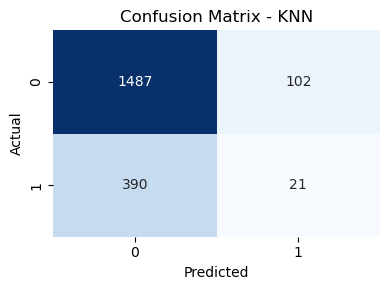

In [47]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [53]:
 #Generate Top-N Recommendations

In [55]:
best_model = models['Gradient Boosting']

## Prepare for recommendations

In [58]:
unique_users = df['user_id'].unique()
unique_items = df['item_id'].unique()
interactions = set(zip(df['user_id'], df['item_id']))

In [60]:
# Sample a few users

In [62]:
sample_users = np.random.choice(unique_users, size=3, replace=False)
top_n = 5
recommendations = {}

In [64]:
# Generate top-N items per user

In [66]:
for user in sample_users:
    candidates = []
    for item in unique_items:
        if (user, item) not in interactions:
            session_id = df['session_id'].mode()[0]
            category = df['category'].mode()[0]
            price = df[df['item_id'] == item]['price'].mean()
            if np.isnan(price):
                continue
            candidates.append([user, item, session_id, category, price])

    candidate_df = pd.DataFrame(candidates, columns=features)
    if not candidate_df.empty:
        probs = best_model.predict_proba(candidate_df)[:, 1]
        candidate_df['score'] = probs
        top_recs = candidate_df.sort_values(by='score', ascending=False).head(top_n)
        recommendations[user] = top_recs[['item_id', 'score']].reset_index(drop=True)


In [68]:
print(recommendations)

{789:    item_id     score
0        1  0.529861
1        7  0.440823
2        8  0.440656
3     4287  0.431182
4      639  0.412942, 70:    item_id     score
0        1  0.522183
1     4287  0.484480
2      639  0.465441
3        7  0.433246
4        8  0.433080, 326:    item_id     score
0        1  0.485409
1     4287  0.423735
2      639  0.408055
3        7  0.397525
4        8  0.397362}


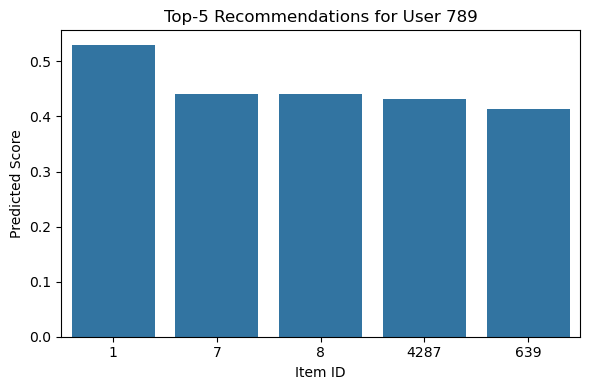

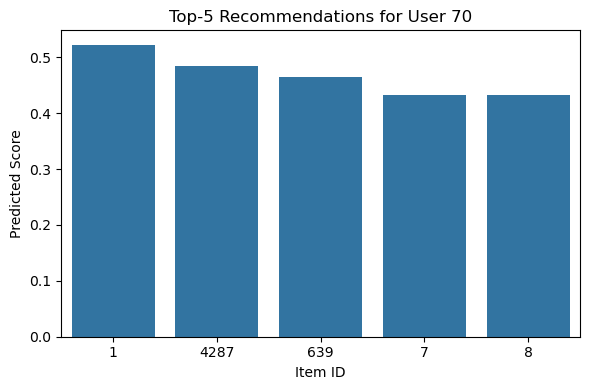

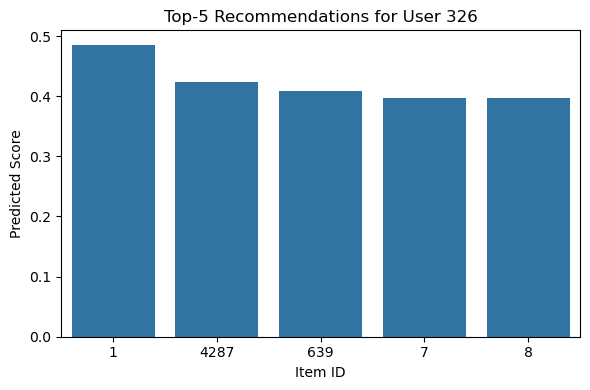

In [70]:
for user, recs in recommendations.items():
    plt.figure(figsize=(6, 4))
    sns.barplot(x=recs['item_id'].astype(str), y=recs['score'])
    plt.title(f"Top-{top_n} Recommendations for User {user}")
    plt.xlabel("Item ID")
    plt.ylabel("Predicted Score")
    plt.tight_layout()
    plt.show()